# Multiclass Text Classification with 
# Logistic Regression Implemented with PyTorch and CE Loss

First, we will do some initialization.

In [6]:
import random
import torch
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm

# enable tqdm in pandas
tqdm.pandas()

# set to True to use the gpu (if there is one available)
use_gpu = True

# select device
device = torch.device('cuda' if use_gpu and torch.cuda.is_available() else 'cpu')
print(f'device: {device.type}')

# random seed
seed = 1234

# set random seed
if seed is not None:
    print(f'random seed: {seed}')
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)

device: cpu
random seed: 1234


We will be using the AG's News Topic Classification Dataset.
It is stored in two CSV files: `train.csv` and `test.csv`, as well as a `classes.txt` that stores the labels of the classes to predict.

First, we will load the training dataset using [pandas](https://pandas.pydata.org/) and take a quick look at how the data.

In [7]:
#Aqui leemos los datos de entrenamiento
train_df = pd.read_csv('/kaggle/input/ag-news-classification-dataset/train.csv')
train_df.columns = ['class index', 'title', 'description'] #Definimos las 3 columnas, clase, titulo y descripción
train_df

FileNotFoundError: [Errno 2] No such file or directory: '/kaggle/input/ag-news-classification-dataset/train.csv'

The dataset consists of 120,000 examples, each consisting of a class index, a title, and a description.
The class labels are distributed in a separated file. We will add the labels to the dataset so that we can interpret the data more easily. Note that the label indexes are one-based, so we need to subtract one to retrieve them from the list.

In [ ]:
# Abrimos y leemos las etiquetas de clase desde un archivo de texto
labels = open('/kaggle/input/classes/classes.txt').read().splitlines()

# Asignamos las etiquetas a cada índice en 'train_df' y creamos una columna 'class'
classes = train_df['class index'].map(lambda i: labels[i-1])
train_df.insert(1, 'class', classes)

# Seleccionamos el 80% de 'train_df' aleatoriamente para el entrenamiento
train_df = train_df.sample(frac=0.8, random_state=42)

# Mostramos el DataFrame actualizado
train_df

,class index,class,title,description
71787,3,Business,"BBC set for major shake-up, claims newspaper","London - The British Broadcasting Corporation,..."
67218,3,Business,Marsh averts cash crunch,Embattled insurance broker #39;s banks agree t...
54066,2,Sports,"Jeter, Yankees Look to Take Control (AP)",AP - Derek Jeter turned a season that started ...
7168,4,Sci/Tech,Flying the Sun to Safety,When the Genesis capsule comes back to Earth w...
29618,3,Business,Stocks Seen Flat as Nortel and Oil Weigh,NEW YORK (Reuters) - U.S. stocks were set to ...
...,...,...,...,...
59228,4,Sci/Tech,Investors Flock to Web Networking Sites,"Internet whiz kids Marc Andreessen, Josh Kopel..."
61417,3,Business,Samsung Electric Quarterly Profit Up,Samsung Electronics Co. Ltd. #39;s (005930.KS:...
20703,3,Business,Coeur Still Committed to Wheaton Deal,Coeur d #39;Alene Mines Corp. said Tuesday tha...
40626,3,Business,Clouds on horizon for low-cost airlines,NEW YORK -- As larger US airlines suffer growi...


Let's inspect how balanced our examples are by using a bar plot.

/tmp/ipykernel_30/1245903889.py:1: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  pd.value_counts(train_df['class']).plot.bar()


<Axes: xlabel='class'>

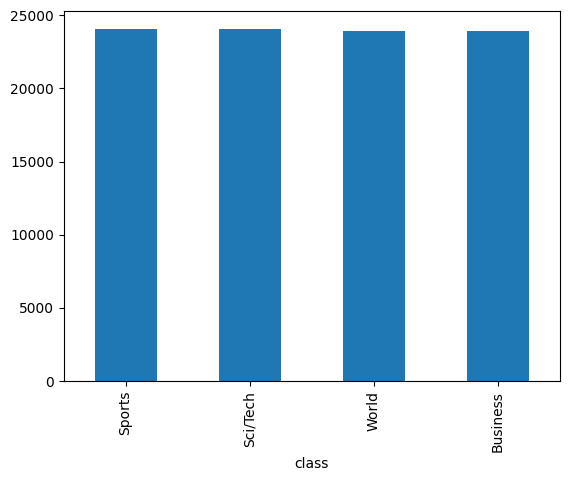

In [ ]:
# Contamos la frecuencia de cada clase en 'train_df' y la mostramos en un gráfico de barras
pd.value_counts(train_df['class']).plot.bar()

The classes are evenly distributed. That's great!

However, the text contains some spurious backslashes in some parts of the text.
They are meant to represent newlines in the original text.
An example can be seen below, between the words "dwindling" and "band".

In [ ]:
# Imprimimos la descripción del primer registro en 'train_df'
print(train_df.loc[0, 'description'])

Reuters - Short-sellers, Wall Street's dwindling\band of ultra-cynics, are seeing green again.


We will replace the backslashes with spaces on the whole column using pandas replace method.

In [ ]:

# Convertimos los textos en 'title' y 'description' a minúsculas
title = train_df['title'].str.lower()
descr = train_df['description'].str.lower()

# Concatenamos 'title' y 'description' en una sola columna 'text'
text = title + " " + descr

# Reemplazamos las barras invertidas ('\') en 'text' por espacios y agregamos la columna a 'train_df'
train_df['text'] = text.str.replace('\\', ' ', regex=False)

# Mostramos el DataFrame actualizado
train_df

,class index,class,title,description,text
71787,3,Business,"BBC set for major shake-up, claims newspaper","London - The British Broadcasting Corporation,...","bbc set for major shake-up, claims newspaper l..."
67218,3,Business,Marsh averts cash crunch,Embattled insurance broker #39;s banks agree t...,marsh averts cash crunch embattled insurance b...
54066,2,Sports,"Jeter, Yankees Look to Take Control (AP)",AP - Derek Jeter turned a season that started ...,"jeter, yankees look to take control (ap) ap - ..."
7168,4,Sci/Tech,Flying the Sun to Safety,When the Genesis capsule comes back to Earth w...,flying the sun to safety when the genesis caps...
29618,3,Business,Stocks Seen Flat as Nortel and Oil Weigh,NEW YORK (Reuters) - U.S. stocks were set to ...,stocks seen flat as nortel and oil weigh new ...
...,...,...,...,...,...
59228,4,Sci/Tech,Investors Flock to Web Networking Sites,"Internet whiz kids Marc Andreessen, Josh Kopel...",investors flock to web networking sites intern...
61417,3,Business,Samsung Electric Quarterly Profit Up,Samsung Electronics Co. Ltd. #39;s (005930.KS:...,samsung electric quarterly profit up samsung e...
20703,3,Business,Coeur Still Committed to Wheaton Deal,Coeur d #39;Alene Mines Corp. said Tuesday tha...,coeur still committed to wheaton deal coeur d ...
40626,3,Business,Clouds on horizon for low-cost airlines,NEW YORK -- As larger US airlines suffer growi...,clouds on horizon for low-cost airlines new yo...


Now we will proceed to tokenize the title and description columns using NLTK's word_tokenize().
We will add a new column to our dataframe with the list of tokens.

In [ ]:
from nltk.tokenize import word_tokenize

# Tokenizamos cada texto en 'train_df' y guardamos los tokens en una nueva columna 'tokens'
train_df['tokens'] = train_df['text'].progress_map(word_tokenize)

# Mostramos el DataFrame actualizado
train_df

  0%|          | 0/96000 [00:00<?, ?it/s]

,class index,class,title,description,text,tokens
71787,3,Business,"BBC set for major shake-up, claims newspaper","London - The British Broadcasting Corporation,...","bbc set for major shake-up, claims newspaper l...","[bbc, set, for, major, shake-up, ,, claims, ne..."
67218,3,Business,Marsh averts cash crunch,Embattled insurance broker #39;s banks agree t...,marsh averts cash crunch embattled insurance b...,"[marsh, averts, cash, crunch, embattled, insur..."
54066,2,Sports,"Jeter, Yankees Look to Take Control (AP)",AP - Derek Jeter turned a season that started ...,"jeter, yankees look to take control (ap) ap - ...","[jeter, ,, yankees, look, to, take, control, (..."
7168,4,Sci/Tech,Flying the Sun to Safety,When the Genesis capsule comes back to Earth w...,flying the sun to safety when the genesis caps...,"[flying, the, sun, to, safety, when, the, gene..."
29618,3,Business,Stocks Seen Flat as Nortel and Oil Weigh,NEW YORK (Reuters) - U.S. stocks were set to ...,stocks seen flat as nortel and oil weigh new ...,"[stocks, seen, flat, as, nortel, and, oil, wei..."
...,...,...,...,...,...,...
59228,4,Sci/Tech,Investors Flock to Web Networking Sites,"Internet whiz kids Marc Andreessen, Josh Kopel...",investors flock to web networking sites intern...,"[investors, flock, to, web, networking, sites,..."
61417,3,Business,Samsung Electric Quarterly Profit Up,Samsung Electronics Co. Ltd. #39;s (005930.KS:...,samsung electric quarterly profit up samsung e...,"[samsung, electric, quarterly, profit, up, sam..."
20703,3,Business,Coeur Still Committed to Wheaton Deal,Coeur d #39;Alene Mines Corp. said Tuesday tha...,coeur still committed to wheaton deal coeur d ...,"[coeur, still, committed, to, wheaton, deal, c..."
40626,3,Business,Clouds on horizon for low-cost airlines,NEW YORK -- As larger US airlines suffer growi...,clouds on horizon for low-cost airlines new yo...,"[clouds, on, horizon, for, low-cost, airlines,..."


Now we will create a vocabulary from the training data. We will only keep the terms that repeat beyond some threshold established below.

In [ ]:

# Definimos un umbral mínimo de frecuencia para los tokens
threshold = 10

# Contamos la frecuencia de cada token en 'train_df' y seleccionamos solo los que superan el umbral
tokens = train_df['tokens'].explode().value_counts()
tokens = tokens[tokens > threshold]

# Creamos un diccionario de tokens: una lista de tokens con '[UNK]' al inicio para palabras desconocidas
id_to_token = ['[UNK]'] + tokens.index.tolist()

# Creamos un diccionario inverso que asigna un ID único a cada token
token_to_id = {w: i for i, w in enumerate(id_to_token)}

# Calculamos y mostramos el tamaño del vocabulario
vocabulary_size = len(id_to_token)
print(f'vocabulary size: {vocabulary_size:,}')

vocabulary size: 17,430


In [ ]:
from collections import defaultdict

# Función para crear un vector de características a partir de los tokens
def make_feature_vector(tokens, unk_id=0):
    # Inicializamos un diccionario para contar la frecuencia de cada token ID
    vector = defaultdict(int)
    
    # Para cada token, obtenemos su ID (o '[UNK]' si no existe) y aumentamos su frecuencia en el vector
    for t in tokens:
        i = token_to_id.get(t, unk_id)
        vector[i] += 1

    return vector

# Aplicamos la función a cada lista de tokens en 'train_df' y guardamos los vectores en la columna 'features'
train_df['features'] = train_df['tokens'].progress_map(make_feature_vector)

# Mostramos el DataFrame actualizado
train_df



  0%|          | 0/96000 [00:00<?, ?it/s]

,class index,class,title,description,text,tokens,features
71787,3,Business,"BBC set for major shake-up, claims newspaper","London - The British Broadcasting Corporation,...","bbc set for major shake-up, claims newspaper l...","[bbc, set, for, major, shake-up, ,, claims, ne...","{2447: 1, 167: 1, 11: 1, 201: 1, 6854: 2, 2: 5..."
67218,3,Business,Marsh averts cash crunch,Embattled insurance broker #39;s banks agree t...,marsh averts cash crunch embattled insurance b...,"[marsh, averts, cash, crunch, embattled, insur...","{1950: 2, 0: 2, 723: 1, 5094: 1, 2887: 1, 749:..."
54066,2,Sports,"Jeter, Yankees Look to Take Control (AP)",AP - Derek Jeter turned a season that started ...,"jeter, yankees look to take control (ap) ap - ...","[jeter, ,, yankees, look, to, take, control, (...","{6680: 2, 2: 1, 508: 1, 599: 1, 4: 1, 193: 1, ..."
7168,4,Sci/Tech,Flying the Sun to Safety,When the Genesis capsule comes back to Earth w...,flying the sun to safety when the genesis caps...,"[flying, the, sun, to, safety, when, the, gene...","{2606: 1, 1: 4, 415: 2, 4: 3, 1060: 1, 96: 1, ..."
29618,3,Business,Stocks Seen Flat as Nortel and Oil Weigh,NEW YORK (Reuters) - U.S. stocks were set to ...,stocks seen flat as nortel and oil weigh new ...,"[stocks, seen, flat, as, nortel, and, oil, wei...","{158: 2, 646: 1, 1526: 1, 21: 1, 2040: 2, 9: 1..."
...,...,...,...,...,...,...,...
59228,4,Sci/Tech,Investors Flock to Web Networking Sites,"Internet whiz kids Marc Andreessen, Josh Kopel...",investors flock to web networking sites intern...,"[investors, flock, to, web, networking, sites,...","{366: 1, 8553: 1, 4: 1, 227: 1, 2617: 1, 991: ..."
61417,3,Business,Samsung Electric Quarterly Profit Up,Samsung Electronics Co. Ltd. #39;s (005930.KS:...,samsung electric quarterly profit up samsung e...,"[samsung, electric, quarterly, profit, up, sam...","{1745: 2, 2598: 1, 536: 2, 154: 2, 51: 1, 926:..."
20703,3,Business,Coeur Still Committed to Wheaton Deal,Coeur d #39;Alene Mines Corp. said Tuesday tha...,coeur still committed to wheaton deal coeur d ...,"[coeur, still, committed, to, wheaton, deal, c...","{0: 3, 239: 1, 3352: 2, 4: 2, 9745: 2, 131: 1,..."
40626,3,Business,Clouds on horizon for low-cost airlines,NEW YORK -- As larger US airlines suffer growi...,clouds on horizon for low-cost airlines new yo...,"[clouds, on, horizon, for, low-cost, airlines,...","{5531: 1, 10: 1, 7492: 1, 11: 1, 2947: 2, 683:..."


In [ ]:
# Función para convertir el vector de características en un vector denso (array numpy)
def make_dense(feats):
    x = np.zeros(vocabulary_size)  # Creamos un vector de ceros del tamaño del vocabulario
    for k, v in feats.items():     # Llenamos el vector con las frecuencias de cada token ID
        x[k] = v
    return x

# Convertimos cada vector de características en un vector denso y apilamos en una matriz X_train
X_train = np.stack(train_df['features'].progress_map(make_dense))

# Obtenemos las etiquetas de clase y ajustamos los índices para que empiecen desde 0
y_train = train_df['class index'].to_numpy() - 1

# Convertimos X_train y y_train en tensores de PyTorch para su uso en modelos
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train)

  0%|          | 0/96000 [00:00<?, ?it/s]

In [ ]:
from torch import nn
from torch import optim

# Parámetros de entrenamiento
lr = 1.0  # Tasa de aprendizaje
n_epochs = 5  # Número de épocas
n_examples = X_train.shape[0]  # Número de ejemplos de entrenamiento
n_feats = X_train.shape[1]  # Número de características (tamaño del vector)
n_classes = len(labels)  # Número de clases

# Definimos el modelo: una capa lineal que va del número de características a las clases
model = nn.Linear(n_feats, n_classes).to(device)

# Función de pérdida para clasificación multiclase y optimizador SGD
loss_func = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=lr)

# Bucle de entrenamiento
indices = np.arange(n_examples)  # Índices para recorrer los ejemplos
for epoch in range(n_epochs):
    np.random.shuffle(indices)  # Mezclamos los ejemplos en cada época
    for i in tqdm(indices, desc=f'epoch {epoch+1}'):
        model.zero_grad()  # Reiniciamos los gradientes en cada paso

        # Preparamos las entradas y la etiqueta verdadera, moviéndolas al dispositivo
        x = X_train[i].unsqueeze(0).to(device)
        y_true = y_train[i].unsqueeze(0).to(device)

        # Calculamos la predicción y la pérdida
        y_pred = model(x)
        loss = loss_func(y_pred, y_true)

        # Calculamos el gradiente y actualizamos los pesos

epoch 1:   0%|          | 0/96000 [00:00<?, ?it/s]

epoch 2:   0%|          | 0/96000 [00:00<?, ?it/s]

epoch 3:   0%|          | 0/96000 [00:00<?, ?it/s]

epoch 4:   0%|          | 0/96000 [00:00<?, ?it/s]

epoch 5:   0%|          | 0/96000 [00:00<?, ?it/s]

Next, we evaluate on the test dataset

In [ ]:

# Cargamos el conjunto de prueba y configuramos las columnas
test_df = pd.read_csv('/kaggle/input/ag-news-classification-dataset/test.csv')
test_df.columns = ['class index', 'title', 'description']

# Combinamos 'title' y 'description' en minúsculas y limpiamos barras invertidas
test_df['text'] = test_df['title'].str.lower() + " " + test_df['description'].str.lower()
test_df['text'] = test_df['text'].str.replace('\\', ' ', regex=False)

# Tokenizamos el texto y creamos vectores de características
test_df['tokens'] = test_df['text'].progress_map(word_tokenize)
test_df['features'] = test_df['tokens'].progress_map(make_feature_vector)

# Seleccionamos aleatoriamente el 70% del conjunto de prueba
test_df = test_df.sample(frac=0.7, random_state=42)

# Convertimos los vectores de características en densos y obtenemos las etiquetas de clase
X_test = np.stack(test_df['features'].progress_map(make_dense))
y_test = test_df['class index'].to_numpy() - 1

# Convertimos X_test e y_test en tensores de PyTorch
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test)

  0%|          | 0/7600 [00:00<?, ?it/s]

  0%|          | 0/7600 [00:00<?, ?it/s]

  0%|          | 0/5320 [00:00<?, ?it/s]

In [ ]:
from sklearn.metrics import classification_report

# Configuramos el modelo en modo evaluación
model.eval()

# Evaluamos el modelo sin calcular gradientes (más eficiente)
with torch.no_grad():
    X_test = X_test.to(device)  # Movemos los datos de prueba al dispositivo
    y_pred = torch.argmax(model(X_test), dim=1)  # Obtenemos las predicciones de clase más probable
    y_pred = y_pred.cpu().numpy()  # Convertimos las predicciones a formato numpy
    print(classification_report(y_test, y_pred, target_names=labels))  # Mostramos el reporte de clasificación

NameError: name 'model' is not defined